# Importing libraries

In [360]:
# for data
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='white', rc={'axes.facecolor': (0,0,0,0)})

# for text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Importing the data

In [6]:
# Read the data
df = pd.read_csv('book_genre_dataset.csv')

# Get shape and head
print(df.shape)
df.head()

(4657, 4)


,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [255]:
# Get the labels
labels = df.genre

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4657 entries, 0 to 4656
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    4657 non-null   int64 
 1   title    4657 non-null   object
 2   genre    4657 non-null   object
 3   summary  4657 non-null   object
dtypes: int64(1), object(3)
memory usage: 145.7+ KB


# Data exploration

In [256]:
# Get genre value counts
genre_counts = df['genre'].value_counts()
print(genre_counts)

thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: genre, dtype: int64


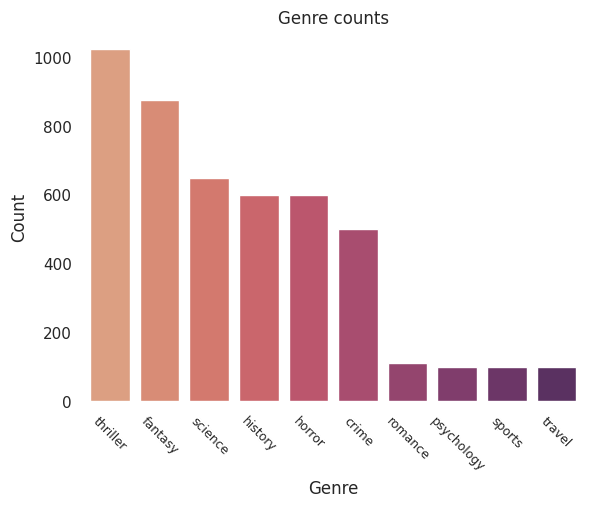

In [156]:
# Initialize the matplotlib figure
fig, ax = plt.subplots()

# Plot the data
sns.barplot(
    x = genre_counts.index,
    y = genre_counts,
    palette = 'flare'
)

# Add axis labels, make pretty
plt.title('Genre counts')
ax.set(
    xlabel = "Genre",
    ylabel = "Count"
)
ax.tick_params(axis='x', labelrotation=-45, labelsize=9)
sns.despine(left=True, bottom=True)

Text(0.5, 1.0, 'Genre percentages')

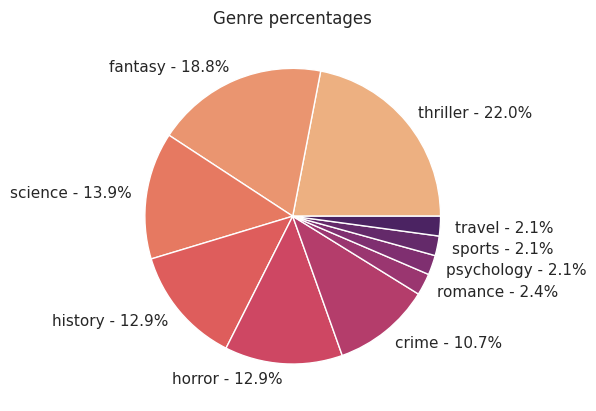

In [11]:
percentages = 100 * genre_counts / genre_counts.sum()
labels = [f"{x} - {y:.1f}%" for x,y in zip(genre_counts.index,percentages)]
colors = plt.get_cmap('flare')(np.linspace(0,1,len(percentages)))

plt.figure()

plt.pie(
    x=genre_counts,
    labels=labels,
    colors=colors
)

plt.title("Genre percentages")

# Text Preprocessing

- lowercase
- remove punctuation
- remove stopwords
- stemming/lemmatization
- combine title and summary into new column

In [28]:
# Create new column with combined title and summary
df['combined'] = df['title'] + '. ' + df['summary']

In [29]:
# Make everything lowercase
def lowercase(text):
    text = text.lower()
    return text

# Remove punctuation
def remove_punct(text):
    text = re.sub(r'[^\w\s]|_', '', text)
    return text

# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = ' '.join([w for w in text.split() if w not in stop_words])
    return text

# Lemmatize tokens
def get_lemmas(text):
    wnl = WordNetLemmatizer()
    text = ' '.join([wnl.lemmatize(w) for w in text.split()])
    return text

In [30]:
# Preprocessing
def preprocessing(text):
    text = lowercase(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    text = get_lemmas(text)
    return text

In [208]:
df['combined_clean'] = df['combined'].apply(preprocessing)

# Feature engineering
- number of characters (title/summary)
- number of words (title/summary)
- number of sentences (summary)
- number of unique words (summary)
- number of stopwords (title/summary)
- average word length (combined)
- average sentence length (summary)
- ratio of unique words to total number of words (combined)
- ratio of stopwords to total number of words (combined)
- sentiment analysis (TextBlob)
- count of recognized NER categories (e.g. PERSON, NORP, etc. w/ spaCy)

For each feature, look at bivariate distributions of these features across all genres. The histograms and densities (since sample sizes vary so much) allow us to see if a variable is predictive.

### Number of characters

We create two features that track character counts:
- **title\_char\_count**: the number of characters in the book title
- **summary\_char\_count**: the number of characters in the book summary

In [132]:
def char_count(text):
    return len(text)

df['title_char_count'] = df['title'].apply(char_count)
df['summary_char_count'] = df['summary'].apply(char_count)

In [508]:
# TODO: use displot or histplot with kde=True in order to get
# histogram with kde overlaid
# TODO: use Pearson's first skewness coefficient (or mode skewness)
#     (mean - mode) / std_dev
# to quantify the skew and therefore justify the use of log scale
# Would it maybe be sufficient to place a dot/line at the mean of
# the distribution?
# scipy.stats.kurtosis and scipy.stats.skew
def feature_ridge_plot_by_genre(feature, log=True):
    # Initialize the FacetGrid object
    g = sns.FacetGrid(
            df, row='genre', hue='genre',
            aspect=13, height=0.7, palette='flare'
        )
    
    # Draw the densities
    g.map(
        sns.kdeplot, feature, bw_adjust=.5,
        clip_on=False, fill=True, alpha=1,
        linewidth=1.5, log_scale=log
    )
    # Create version with bigger (white) linewidth to create
    # visual separation between overlapping densities
    g.map(sns.kdeplot, feature, bw_adjust=.5,
          clip_on=False, color='w', linewidth=2,
          log_scale=log
    )

    # Draw reference line at y=0 for each facet
    # Passing color=None uses the hue mapping for the refline
    g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)

    # Define and use a simple function to label the plot
    # in axes coordinates
    def label(x,color,label):
        ax = plt.gca()
        ax.text(0,.2,label,fontweight='bold',color=color,ha='left',va='center',transform=ax.transAxes)

    g.map(label, 'genre')

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)
    
    # Remove extraneous axes details
    g.set_titles("")
    g.set(yticks=[],ylabel="",xlabel="")
    g.despine(bottom=True,left=True)
    
    # Set title and xlabel for the entire figure
    g.figure.suptitle(
        f"Probability density of {feature} by genre",
        verticalalignment='bottom',
        x=0.54, y=0.94
    )
    g.figure.supxlabel(feature, va='bottom', x=0.54)

In [509]:
def feature_density_by_genre(feature, log=True):
    fig, ax = plt.subplots()

    sns.kdeplot(
        data=df,
        x=feature,
        hue='genre',
        palette='colorblind',
        common_norm=False,
        log_scale=log
    )
    
    sns.despine()

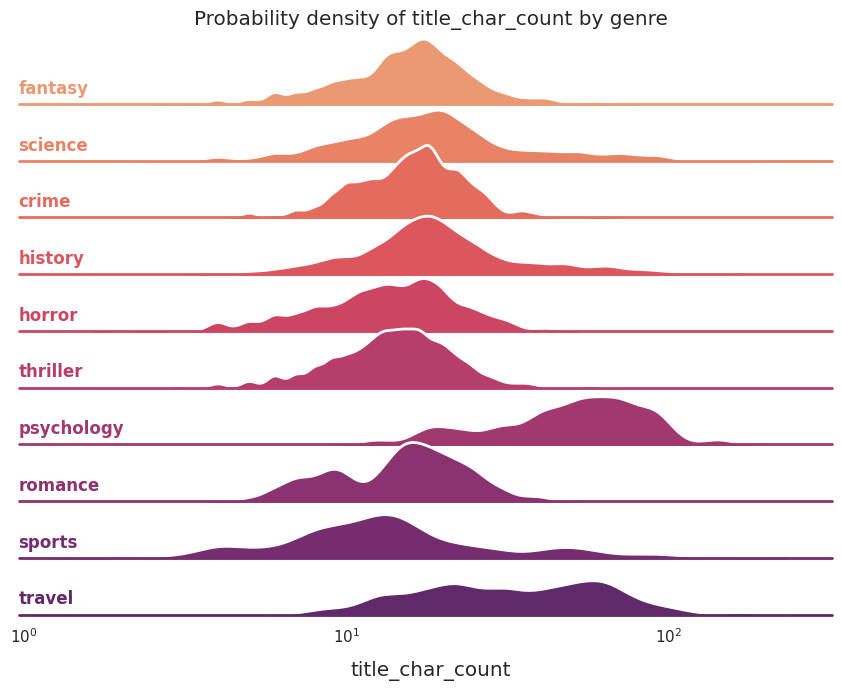

In [512]:
#feature_density_by_genre('title_char_count')
feature_ridge_plot_by_genre('title_char_count')

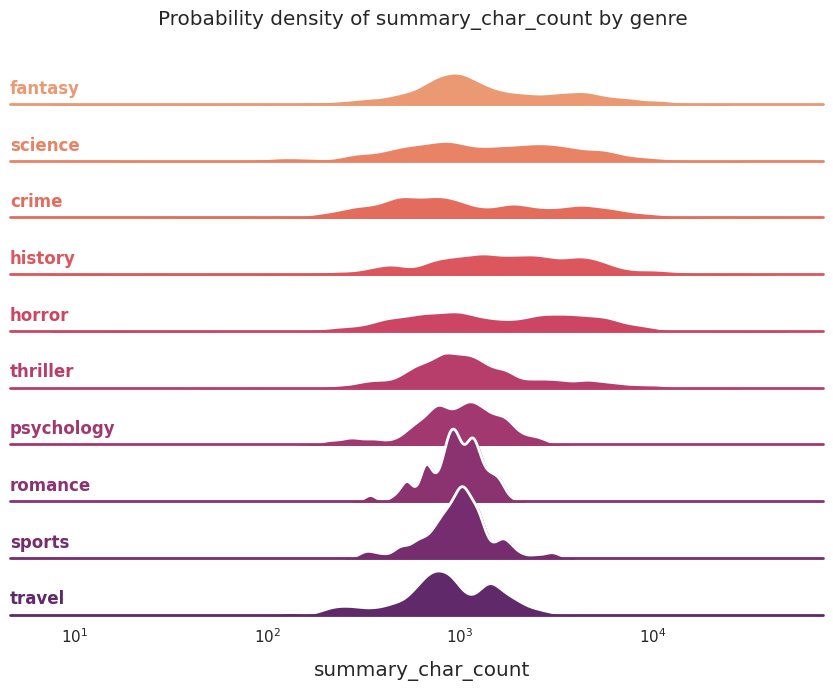

In [409]:
#feature_density_by_genre('summary_char_count')
feature_ridge_plot_by_genre('summary_char_count')

### Number of words
- **title\_word\_count**: the number of words in the book title
- **summary\_word\_count**: the number of words in the book summary

In [410]:
def word_count(text):
    return len(text.split())

df['title_word_count'] = df['title'].apply(word_count)
df['summary_word_count'] = df['summary'].apply(word_count)

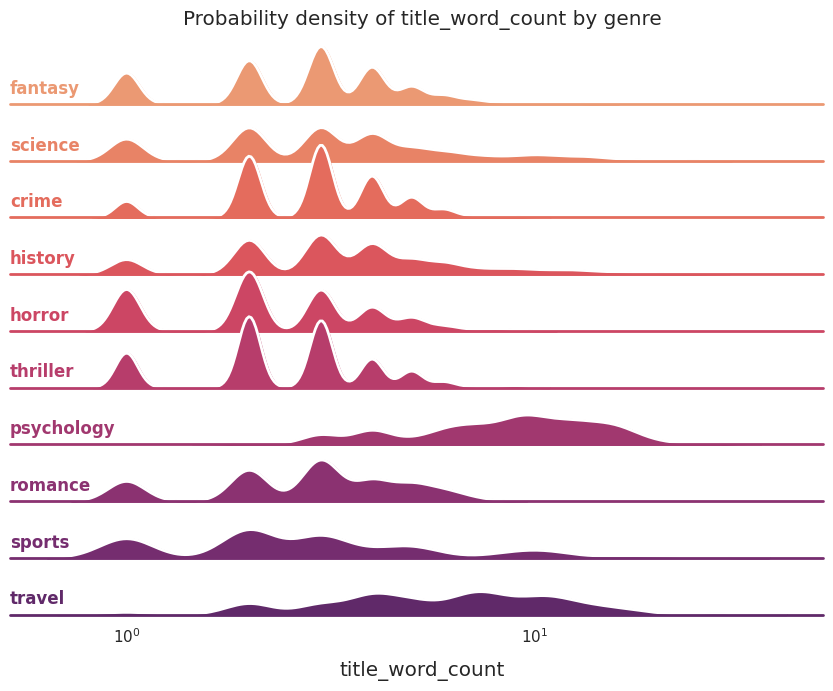

In [411]:
feature_ridge_plot_by_genre('title_word_count')

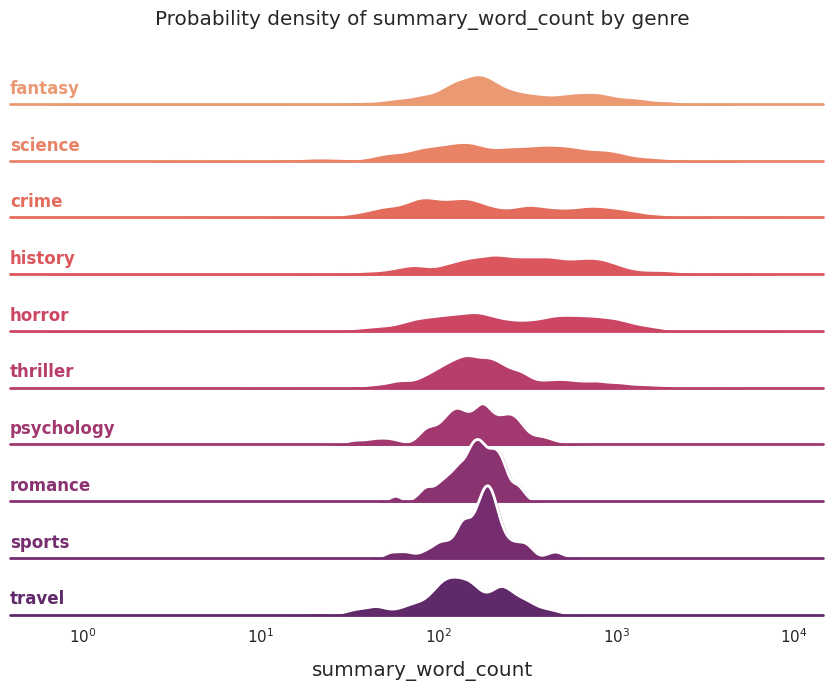

In [412]:
feature_ridge_plot_by_genre('summary_word_count')

### Number of sentences
- **sent_count**: the number of sentences in the summary

**NB**: doesn't make sense to talk about the number of sentences in the title, since they're so often short fragments and not full sentences

In [413]:
def sent_count(text):
    return len(sent_tokenize(text))

df['sent_count'] = df['summary'].apply(sent_count)

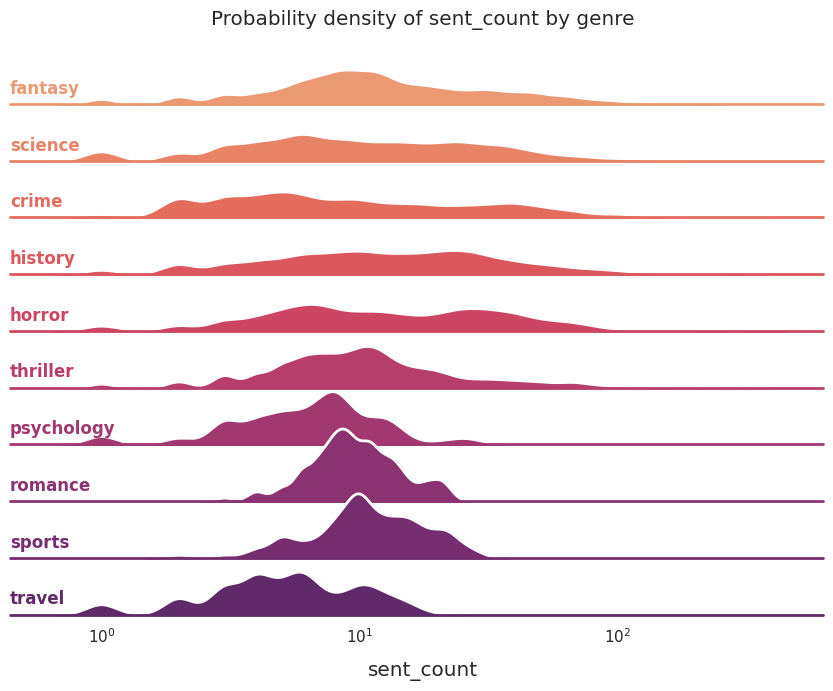

In [414]:
feature_ridge_plot_by_genre('sent_count')

### Specific word counts
- **unique\_word\_count**: the number of unique words in the combined book title and summary
    - use combined here because the summary often contains the title itself
- **title\_stopword\_count**: the number of stopwords in the book title
- **summary\_stopword\_count**: the number of stopwords in the book summary

In [415]:
def unique_word_count(text):
    return len(set(remove_punct(text).split(' ')))
    
df['unique_word_count'] = df['combined'].apply(unique_word_count)

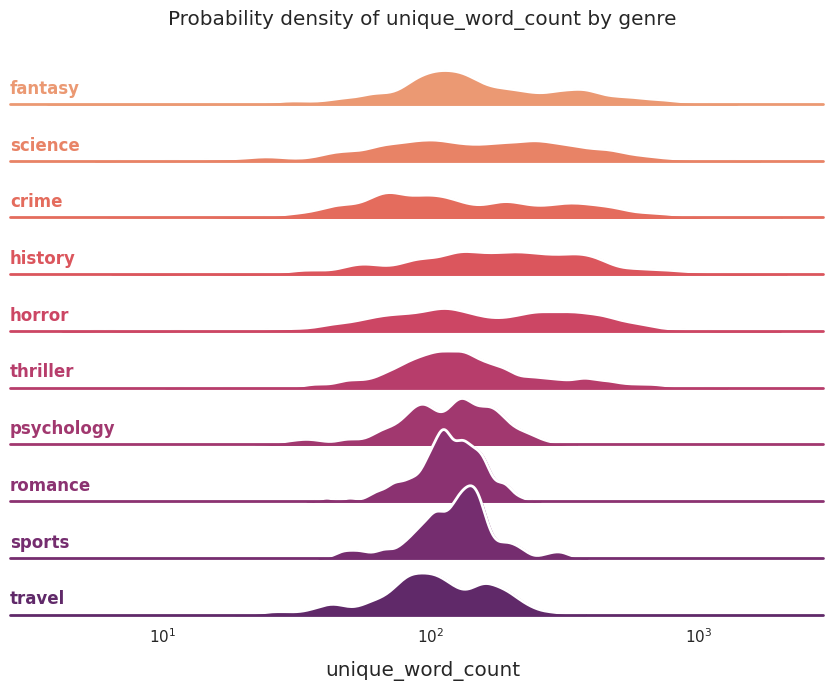

In [416]:
feature_ridge_plot_by_genre('unique_word_count')

In [417]:
def stopword_count(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = remove_punct(text)
    stopwords_in_text = [w for w in text.split() if w in stop_words]
    return len(stopwords_in_text)

df['title_stopword_count'] = df['title'].apply(stopword_count)
df['summary_stopword_count'] = df['summary'].apply(stopword_count)

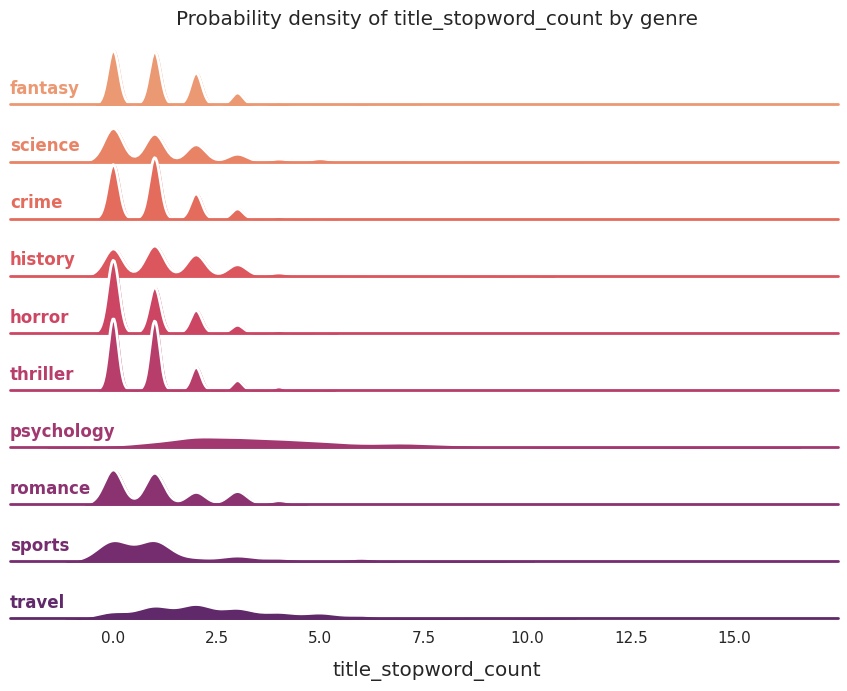

In [495]:
feature_ridge_plot_by_genre('title_stopword_count',log=False)

,index,title,genre,summary,combined,combined_clean,char_count,word_count,title_char_count,summary_char_count,...,title_word_count,summary_word_count,sent_count,unique_word_count,title_stopword_count,summary_stopword_count,title_avg_word_length,summary_avg_word_length,avg_sent_length,sentiment_score
588,588,Missing Men of Saturn,science,~Plot outline description~ -->,Missing Men of Saturn. ~Plot outline descript...,missing men saturn plot outline description,54,8,21,31,...,4,4,1,8,1,0,5.250000,7.750000,4.0,-0.296
834,834,Stadium Beyond the Stars,science,- ~Plot outline description,Stadium Beyond the Stars. - ~Plot outline desc...,stadium beyond star plot outline description,53,8,24,27,...,4,4,1,8,1,0,6.000000,6.750000,4.0,0.000
1772,1772,Grania: She-King of the Irish Seas,history,~Plot outline description~ --> <!--,Grania: She-King of the Irish Seas. ~Plot out...,grania sheking irish sea plot outline description,72,11,34,36,...,6,5,1,10,2,0,5.666667,7.200000,5.0,0.000
2485,2485,Created By,horror,~Plot outline description,Created By. ~Plot outline description,created plot outline description,38,5,10,26,...,2,3,1,6,1,0,5.000000,8.666667,3.0,0.250


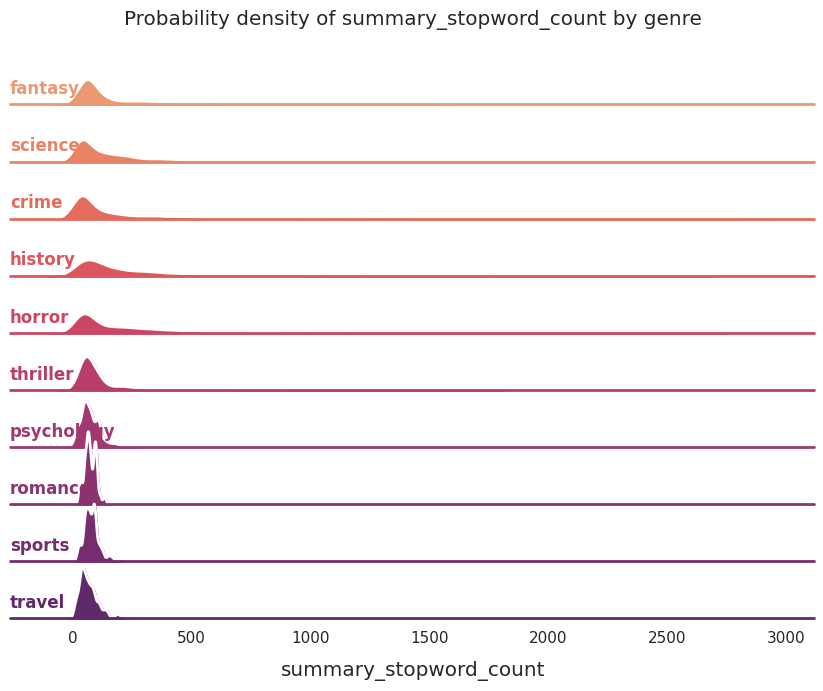

In [522]:
feature_ridge_plot_by_genre('summary_stopword_count',log=False)
df[df['summary'].apply(preprocessing)=='plot outline description'].head(21)

### Averages
- **title\_avg\_word\_length**: the average number of characters per word in book title
- **summary\_avg\_word\_length**: the average number of characters per word in book summary
- **avg\_sent\_length**: the average number of words per sentence in book summary

In [223]:
df['title_avg_word_length'] = df['title_char_count'] / df['title_word_count']
df['summary_avg_word_length'] = df['summary_char_count'] / df['summary_word_count']

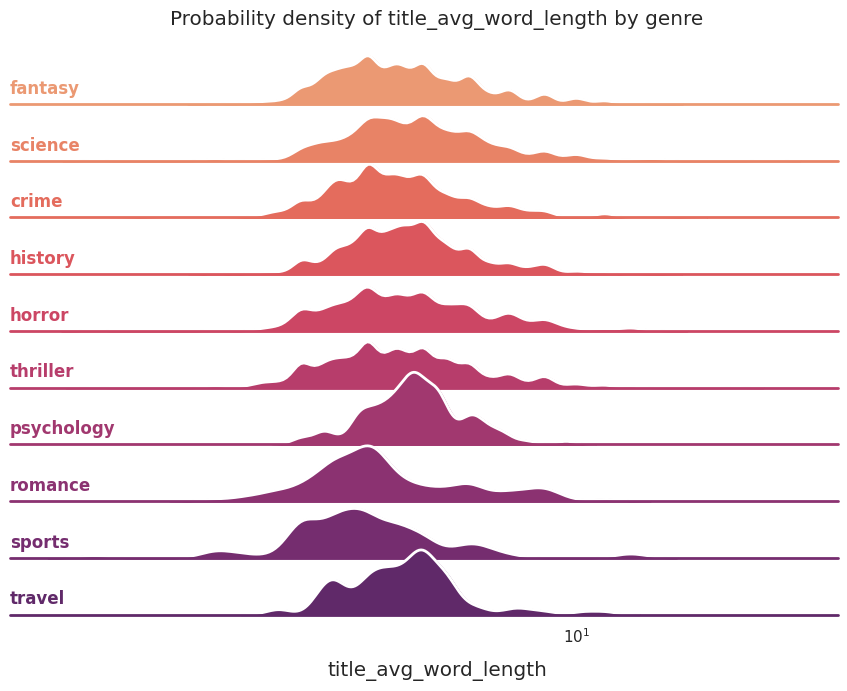

In [430]:
feature_ridge_plot_by_genre('title_avg_word_length')

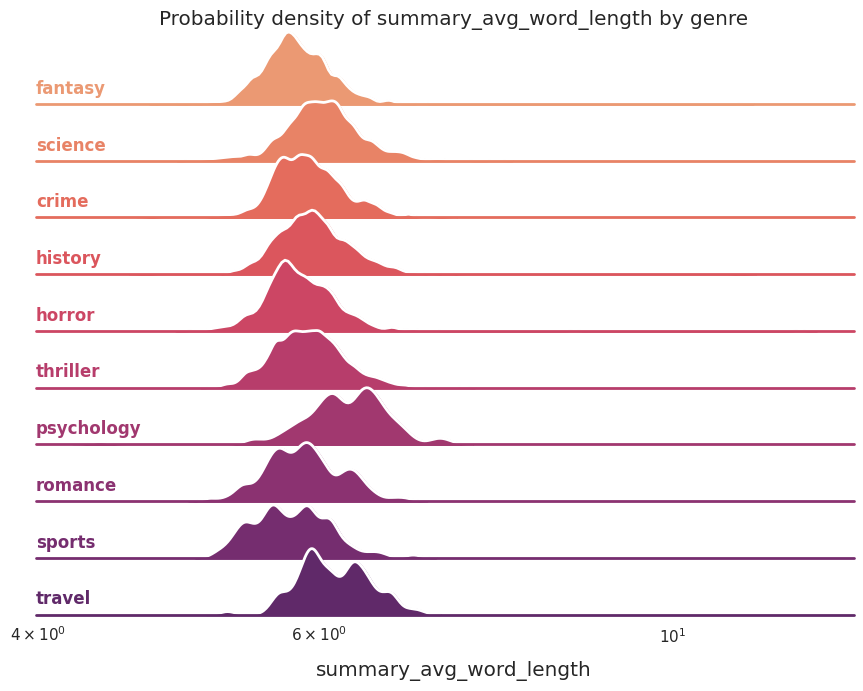

In [431]:
feature_ridge_plot_by_genre('summary_avg_word_length')

In [231]:
df['avg_sent_length'] = df['summary_word_count'] / df['sent_count']

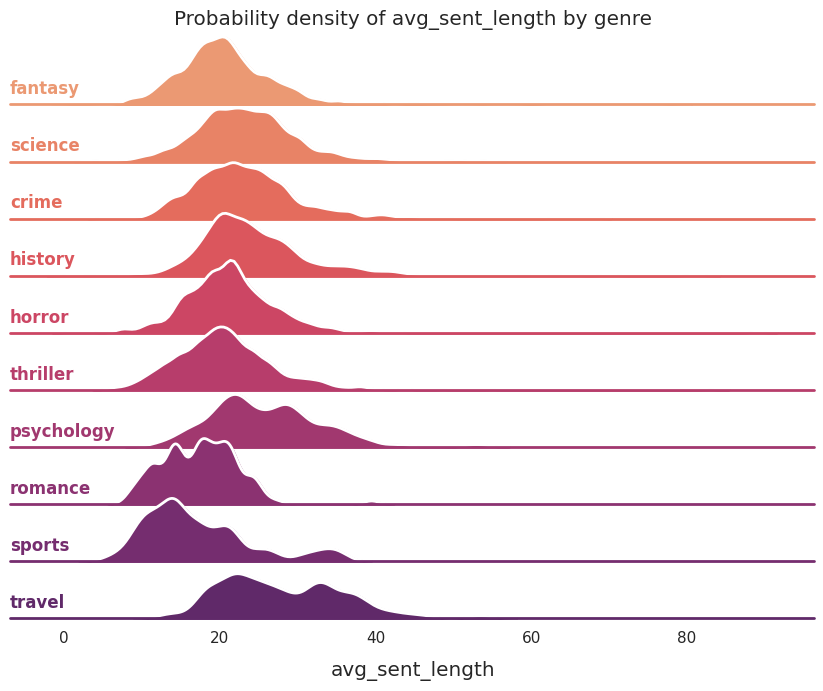

In [433]:
feature_ridge_plot_by_genre('avg_sent_length', log=False)

In [491]:
from scipy.stats import skew, kurtosis
print(df.groupby("genre")['avg_sent_length'].apply(skew))
print(df.groupby('genre')['avg_sent_length'].apply(lambda x : kurtosis(x,fisher=True)))
print(skew(df['title_stopword_count']))
print(kurtosis(df['title_stopword_count'],fisher=True))

genre
crime         1.452589
fantasy       1.836594
history       1.971680
horror        2.347402
psychology    0.734831
romance       0.716605
science       0.808061
sports        1.005675
thriller      1.447565
travel        0.531397
Name: avg_sent_length, dtype: float64
genre
crime          5.749538
fantasy       10.212033
history        8.486735
horror        23.411818
psychology     1.153764
romance        2.274882
science        2.432351
sports         0.477194
thriller       9.238006
travel        -0.023855
Name: avg_sent_length, dtype: float64
2.2387243764571685
8.894636679763524


## Sentiment Analysis

In [253]:
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['combined'].apply(lambda x :
                                            sia.polarity_scores(x)['compound'])

-0.9998
0.9985


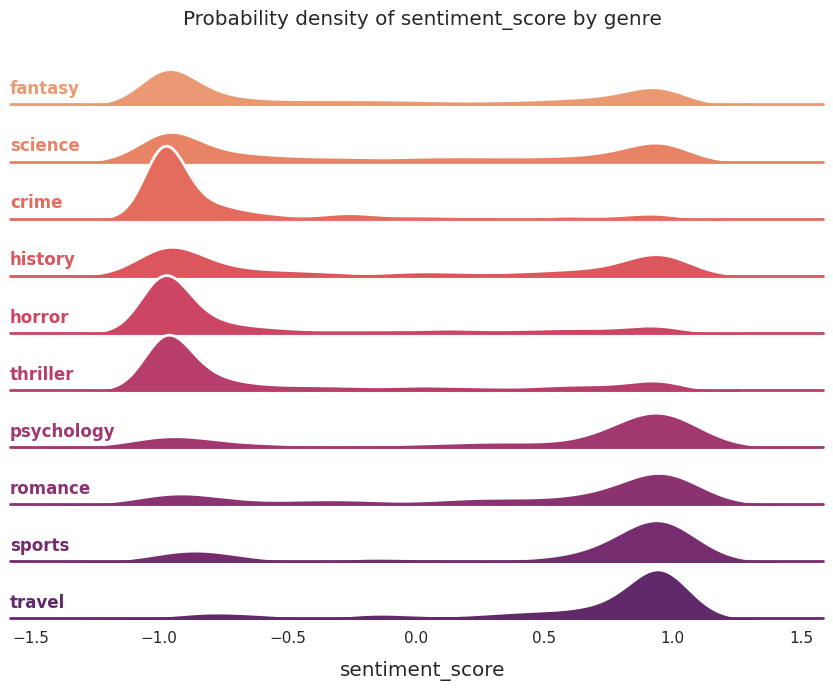

In [515]:
feature_ridge_plot_by_genre('sentiment_score', log=False)
print(df[df['genre']=='history']['sentiment_score'].min())
print(df[df['genre']=='history']['sentiment_score'].max())

## Named-Entity Recognition (NER)